In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
from torchvision import transforms
import torchvision
import numpy as np
from resnet import ResNet, Bottleneck

class Trainer:
    def __init__(self, name, model, criterion, optimizer, device):
        """
        Initializes the Trainer.

        Args:
            model (nn.Module): The PyTorch model to train.
            criterion (nn.Module): The loss function.
            optimizer (torch.optim.Optimizer): The optimizer.
            device (torch.device): The device to train on (e.g., 'cuda' or 'cpu').
        """
        self.name = name
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def train_epoch(self, dataloader):
        """
        Trains the model for one epoch.

        Args:
            dataloader (DataLoader): The DataLoader for the training set.

        Returns:
            float: The average training loss for the epoch.
        """
        self.model.train()
        total_loss = 0.0
        num_batches = len(dataloader)

        for inputs, labels in dataloader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / num_batches
        self.train_losses.append(avg_loss)
        return avg_loss

    def validate_epoch(self, dataloader):
        """
        Evaluates the model on the validation set for one epoch.

        Args:
            dataloader (DataLoader): The DataLoader for the validation set.

        Returns:
            float: The average validation loss for the epoch.
            float: The average validation accuracy for the epoch.
        """
        self.model.eval()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        num_batches = len(dataloader)

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        avg_loss = total_loss / num_batches
        accuracy = correct_predictions / total_samples
        self.val_losses.append(avg_loss)
        self.val_accuracies.append(accuracy)
        return avg_loss, accuracy

    def train(self, train_dataloader, val_dataloader, num_epochs):
        """
        Trains the model for a specified number of epochs and validates it, recording latency and throughput.

        Args:
            train_dataloader (DataLoader): The DataLoader for the training set.
            val_dataloader (DataLoader): The DataLoader for the validation set.
            num_epochs (int): The number of training epochs.
        """
        print(f"Training on {self.device}")
        for epoch in range(num_epochs):
            train_loss = self.train_epoch(train_dataloader)
            val_loss, val_acc = self.validate_epoch(val_dataloader)
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}")

    def plot_losses_accuracies(self):
        """
        Plots the training loss, validation loss, and validation accuracy against the number of epochs.
        """
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure()
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.plot(epochs, self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(self.name + ' Training and Validation Loss')
        plt.legend()
        plt.show()

trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
# Load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=trans)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=trans)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256)

@torch.no_grad()
def measure_inference_time_with_warmup(model, data_loader, warmup_steps=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    # Warm-up
    for i, (inputs, _) in enumerate(data_loader):
        inputs = inputs.to(device)
        _ = model(inputs)
        if i >= warmup_steps - 1:
            break

    total_inference_time = 0
    num_samples = 0
    start_time = time.time() # Start timer after warm-up

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        _ = model(inputs)
        num_samples += inputs.size(0)

    end_time = time.time()
    total_inference_time = end_time - start_time
    throughput = num_samples / total_inference_time
    avg_latency_per_sample = total_inference_time / num_samples
    print(f"Average Latency per Sample (with warm-up): {avg_latency_per_sample * 1000:.2f} ms")
    print(f"Throughput (with warm-up): {throughput:.2f} samples/second")
    return avg_latency_per_sample, throughput

def fit_one(name,model,epochs,train_dataloader,val_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainer = Trainer(name = name,model = model,criterion = nn.CrossEntropyLoss(),optimizer= optim.SGD(model.parameters(),weight_decay=0.0001,momentum=0.9),device=device)
    trainer.train(train_dataloader, val_dataloader, epochs)
    trainer.plot_losses_accuracies()
    max_acc = np.max(trainer.val_accuracies)
    avg_latency, throughput = measure_inference_time_with_warmup(model, val_dataloader)
    return avg_latency,max_acc

100%|██████████| 170M/170M [00:18<00:00, 9.11MB/s]


Training on cuda
Epoch [1/20], Train Loss: 1.7126, Val Loss: 1.5649, Val Acc: 0.4337
Epoch [2/20], Train Loss: 1.3680, Val Loss: 1.3725, Val Acc: 0.5038
Epoch [3/20], Train Loss: 1.2159, Val Loss: 1.3431, Val Acc: 0.5239
Epoch [4/20], Train Loss: 1.0984, Val Loss: 1.2027, Val Acc: 0.5680
Epoch [5/20], Train Loss: 0.9984, Val Loss: 1.1835, Val Acc: 0.5802
Epoch [6/20], Train Loss: 0.9054, Val Loss: 1.1480, Val Acc: 0.5975
Epoch [7/20], Train Loss: 0.8159, Val Loss: 1.1874, Val Acc: 0.5947
Epoch [8/20], Train Loss: 0.7327, Val Loss: 1.1553, Val Acc: 0.6024
Epoch [9/20], Train Loss: 0.6466, Val Loss: 1.1614, Val Acc: 0.6069
Epoch [10/20], Train Loss: 0.5575, Val Loss: 1.2133, Val Acc: 0.6006
Epoch [11/20], Train Loss: 0.4731, Val Loss: 1.2130, Val Acc: 0.6119
Epoch [12/20], Train Loss: 0.3942, Val Loss: 1.2771, Val Acc: 0.5984
Epoch [13/20], Train Loss: 0.3232, Val Loss: 1.2937, Val Acc: 0.6073
Epoch [14/20], Train Loss: 0.2604, Val Loss: 1.3811, Val Acc: 0.6041
Epoch [15/20], Train Loss:

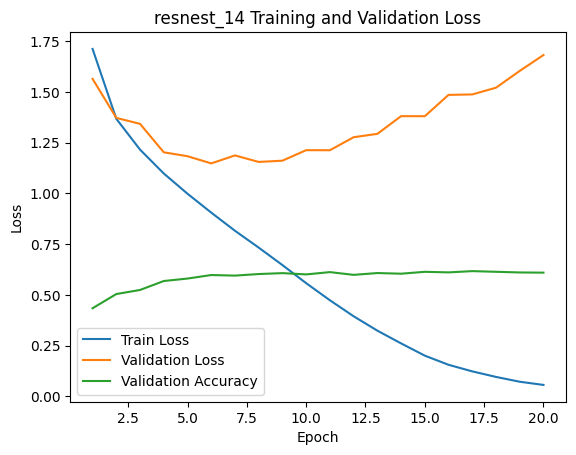

Average Latency per Sample (with warm-up): 0.18 ms
Throughput (with warm-up): 5530.67 samples/second
Training on cuda
Epoch [1/20], Train Loss: 1.9947, Val Loss: 1.7747, Val Acc: 0.3737
Epoch [2/20], Train Loss: 1.6172, Val Loss: 1.5470, Val Acc: 0.4427
Epoch [3/20], Train Loss: 1.4531, Val Loss: 1.4128, Val Acc: 0.4881
Epoch [4/20], Train Loss: 1.3310, Val Loss: 1.3286, Val Acc: 0.5161
Epoch [5/20], Train Loss: 1.2207, Val Loss: 1.4181, Val Acc: 0.5039
Epoch [6/20], Train Loss: 1.1256, Val Loss: 1.3141, Val Acc: 0.5422
Epoch [7/20], Train Loss: 1.0441, Val Loss: 1.2397, Val Acc: 0.5623
Epoch [8/20], Train Loss: 0.9617, Val Loss: 1.2618, Val Acc: 0.5657
Epoch [9/20], Train Loss: 0.8733, Val Loss: 1.2345, Val Acc: 0.5780
Epoch [10/20], Train Loss: 0.7862, Val Loss: 1.2492, Val Acc: 0.5864
Epoch [11/20], Train Loss: 0.7067, Val Loss: 1.3403, Val Acc: 0.5617
Epoch [12/20], Train Loss: 0.6299, Val Loss: 1.4302, Val Acc: 0.5536
Epoch [13/20], Train Loss: 0.5577, Val Loss: 1.4850, Val Acc: 0

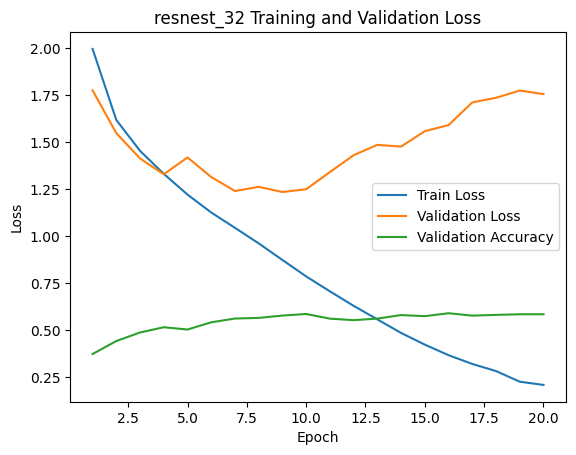

Average Latency per Sample (with warm-up): 0.18 ms
Throughput (with warm-up): 5678.16 samples/second
Training on cuda
Epoch [1/20], Train Loss: 2.1745, Val Loss: 1.8298, Val Acc: 0.3403
Epoch [2/20], Train Loss: 1.7368, Val Loss: 1.5766, Val Acc: 0.4230
Epoch [3/20], Train Loss: 1.5601, Val Loss: 1.7827, Val Acc: 0.4386
Epoch [4/20], Train Loss: 1.4301, Val Loss: 1.4031, Val Acc: 0.4989
Epoch [5/20], Train Loss: 1.3238, Val Loss: 1.3620, Val Acc: 0.5134
Epoch [6/20], Train Loss: 1.2351, Val Loss: 1.2925, Val Acc: 0.5327
Epoch [7/20], Train Loss: 1.1476, Val Loss: 1.2803, Val Acc: 0.5374
Epoch [8/20], Train Loss: 1.0606, Val Loss: 1.2146, Val Acc: 0.5645
Epoch [9/20], Train Loss: 1.0008, Val Loss: 1.2879, Val Acc: 0.5536
Epoch [10/20], Train Loss: 0.9284, Val Loss: 1.2058, Val Acc: 0.5821
Epoch [11/20], Train Loss: 0.8586, Val Loss: 1.2634, Val Acc: 0.5696
Epoch [12/20], Train Loss: 0.8097, Val Loss: 1.2464, Val Acc: 0.5729
Epoch [13/20], Train Loss: 0.7271, Val Loss: 1.2630, Val Acc: 0

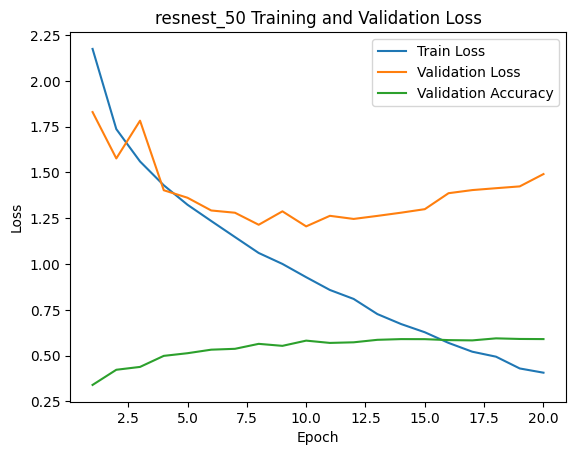

Average Latency per Sample (with warm-up): 0.19 ms
Throughput (with warm-up): 5277.87 samples/second
Training on cuda
Epoch [1/20], Train Loss: 2.2267, Val Loss: 1.9464, Val Acc: 0.3270
Epoch [2/20], Train Loss: 1.8353, Val Loss: 1.7257, Val Acc: 0.4034
Epoch [3/20], Train Loss: 1.6600, Val Loss: 1.6140, Val Acc: 0.4502
Epoch [4/20], Train Loss: 1.5572, Val Loss: 1.5367, Val Acc: 0.4782
Epoch [5/20], Train Loss: 1.4735, Val Loss: 1.4263, Val Acc: 0.4973
Epoch [6/20], Train Loss: 1.3885, Val Loss: 1.4551, Val Acc: 0.5061
Epoch [7/20], Train Loss: 1.3185, Val Loss: 1.4170, Val Acc: 0.5161
Epoch [8/20], Train Loss: 1.2633, Val Loss: 1.3136, Val Acc: 0.5395
Epoch [9/20], Train Loss: 1.1980, Val Loss: 1.3247, Val Acc: 0.5453
Epoch [10/20], Train Loss: 1.1427, Val Loss: 1.3871, Val Acc: 0.5526
Epoch [11/20], Train Loss: 1.0847, Val Loss: 1.3303, Val Acc: 0.5559
Epoch [12/20], Train Loss: 1.0335, Val Loss: 1.3162, Val Acc: 0.5519
Epoch [13/20], Train Loss: 0.9777, Val Loss: 1.3290, Val Acc: 0

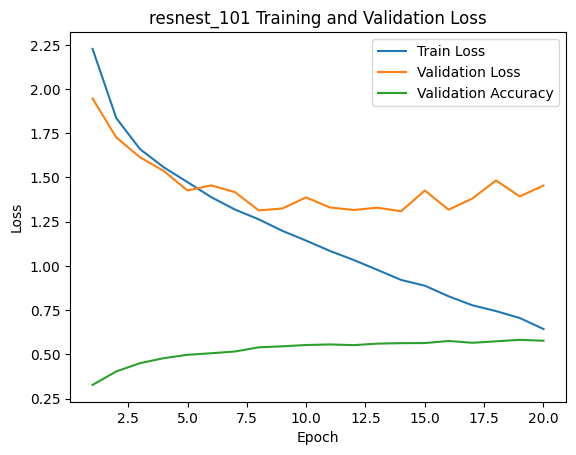

Average Latency per Sample (with warm-up): 0.27 ms
Throughput (with warm-up): 3745.04 samples/second
[('resnest_14', 0.0001808098316192627, np.float64(0.6168)), ('resnest_32', 0.00017611339092254638, np.float64(0.5904)), ('resnest_50', 0.0001894704818725586, np.float64(0.5945)), ('resnest_101', 0.0002670196771621704, np.float64(0.5818))]


In [3]:
model_dict = {}
result_list = []
model_dict['resnest_14'] = ResNet(Bottleneck, [1, 1, 1, 1],
                                  radix=2, groups=1, bottleneck_width=64,
                                  deep_stem=True, stem_width=32, avg_down=True,
                                  avd=True, avd_first=False, num_classes=10,final_drop=0.2)
model_dict['resnest_32'] = ResNet(Bottleneck, [2, 3, 3, 2],
                                  radix=2, groups=1, bottleneck_width=64,
                                  deep_stem=True, stem_width=32, avg_down=True,
                                  avd=True, avd_first=False, num_classes=10,final_drop=0.2)
model_dict['resnest_50'] = ResNet(Bottleneck, [3, 4, 6, 3],
                                  radix=2, groups=1, bottleneck_width=64,
                                  deep_stem=True, stem_width=32, avg_down=True,
                                  avd=True, avd_first=False, num_classes=10,final_drop=0.2)
model_dict['resnest_101'] = ResNet(Bottleneck, [3, 4, 23, 3],
                                  radix=2, groups=1, bottleneck_width=64,
                                  deep_stem=True, stem_width=32, avg_down=True,
                                  avd=True, avd_first=False,num_classes=10,final_drop=0.2)
for name,model in model_dict.items():
    avg_latency,max_acc = fit_one(name,model,20,train_dataloader,val_dataloader)
    result_list.append((name,avg_latency,max_acc))
print(result_list)